# Power Usage Forecasting Project

Codealong with machine learning mastery website: original code and notes at: \
https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

In this project we will use power consumption data to predict future use. The original dataset is available from the following open source link:
https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption#

This project will illustrate multistep, univariate time series forecasting. This means we'll predict, multiple time steps (multistep), into the future our target feature using past values of our target feature only (univariate). 

**Notice - this notebook runs multiple models some of which make use of global functions. Some of the model construction functions have the same name so run the notebook in sequence to avoid confusion.**

### Available Features:

1.date: Date in format dd/mm/yyyy \
2.time: time in format hh:mm:ss \
3.global_active_power: household global minute-averaged active power (in kilowatt) \
4.global_reactive_power: household global minute-averaged reactive power (in kilowatt) \
5.voltage: minute-averaged voltage (in volt) \
6.global_intensity: household global minute-averaged current intensity (in ampere) \
7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). \
8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light. \
9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner. \

In [1]:
# Import data exploration libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')

In [318]:
# Import data science libraries
from math import sqrt
from numpy import split, array
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM
from keras.layers import RepeatVector, TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D

In [4]:
!ls

README.md             data                  power_usage_eda.ipynb
daily_power.csv       power_cleaned.csv


In [5]:
os.listdir("data")

['.DS_Store',
 'household_power_consumption.txt',
 'household_power_consumption.zip']

In [6]:
# Read in the txt file as a dataframe
power = pd.read_csv("data/household_power_consumption.txt", sep=';', infer_datetime_format=True,
                   parse_dates={'datetime':[0,1]}, index_col=['datetime'], low_memory=False)

### High level review and clean

In [7]:
print(power.shape)
power.head()

(2075259, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [8]:
power.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


In [9]:
# we have some object types in the dataset, perhaps this is due to NaN values
power.isna().sum()

Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [10]:
power[power.Sub_metering_3.isna()].head(2)
# So we have nans and a lot of ? marks

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-21 11:23:00,?,?,?,?,?,?,NaN
2006-12-21 11:24:00,?,?,?,?,?,?,NaN


In [11]:
# Mark all '?' with an np.nan marker to allow us to work with data as one array of floats rather than mixed values
power.replace('?', np.nan, inplace=True)

In [12]:
power.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [13]:
# Now let's make all the data points floats
power = power.astype('float32')

In [14]:
#power.info()

### Fill Missing Values

In [15]:
# We can fill missing value with a value at the same time as one day ago
def fill_missing(values):
    one_day = 60*24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            # if the data point is NaN
            if np.isnan(values[row,col]):
                # Fill it with the value from 24hrs earlier
                values[row,col] = values[row-one_day, col]

In [16]:
# Call the funtion with the values from our dataset
fill_missing(power.values)

In [17]:
power.isna().sum() # 0

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

### Create new feature

In [18]:
# calculate new feature for remaining active power (watt-hours) not accounted for by sub-metering
values = power.values
# convert all values from gloabal_active_power feature into watt-hour format, then subtract known submeter values
power['sub_metering_4'] = (values[:,0]*1000/60) - (values[:,4] + values[:,5] + values[:,6])

In [19]:
power.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0,72.333336


### Save dataset as base file in .csv format

In [20]:
power.to_csv('power_cleaned.csv')

In [21]:
!ls

README.md             data                  power_usage_eda.ipynb
daily_power.csv       power_cleaned.csv


## Problem Framing
"Given recent power consumption, what is the expected power consumption for the week ahead?"

This framing requires that a predictive model forecast the total active power for each day over the next seven days.

Technically, this type of problem is referred to as a multi-step time series forecasting problem, given the multiple forecasting steps. A model that makes use of multiploe input variables may be referres to as a multivariate  multi-step time series forecasting model.

As we need daily active power predictions it will make sense to downsample to daily totals:

In [22]:
# load the cleaned set in
df = pd.read_csv("power_cleaned.csv", header=0, infer_datetime_format=True, parse_dates=["datetime"], index_col=['datetime'] )

In [23]:
df.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336


In [24]:
# resample data to daily
daily_groups = df.resample('D')
daily_data = daily_groups.sum()

In [25]:
print(daily_data.shape)
daily_data.head()

(1442, 8)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011


In [26]:
# Let's save this newly created daily dataset to csv format
daily_data.to_csv("daily_power.csv")

In [27]:
daily = pd.read_csv("daily_power.csv", header=0, infer_datetime_format=True, parse_dates=["datetime"], index_col=["datetime"])

## Evaluation Metric

A forecast will be comprised of seven values, one for each day of the week ahead. It is common with multi-step forecasting problems to evaluate each forecasted time step separately. This is helpful for a few reasons. 

+ To comment on the skill at a specific lead time (e.g +1 day vs +3days)
+ To contrast models based on their skills at different lead times (e.g modles good at +1 day vs models good at day +5

It is preferred in this case to use an error metric that has the same units as our target feature: kilowatts. Root mean squared error and mean absolute error are good for this. 

The performance metric for this problem will be the RMSE for each lead time from day 1 to day 7. 

We may also summarize the performance in a single score to assist in deciding the best performing model, overall:

In [354]:
# Create a function that returns the performance of a model based on multiple seven day forecasts.
def evaluate_forecast(actual, predicted):
    scores = list()
    # Calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # Calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # Calculate rmse
        rmse = sqrt(mse)
        # store in the scores list
        scores.append(rmse)
    # Calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row,col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

Running the function will first return the overall RMSE regardless of day, then an array of RMSE scores for each day

## Train Test Split

+ Use first three years for training, final year as test
+ Divide the data into standard weeks, beginning on a Sunday and ending on a Saturday

In [355]:
# We'll need to know what the first Sunday is and the last Saturday to ensure we have complete weeks.
daily["day_of_week"] = daily.index.day_name()
daily["year"] = daily.index.year
daily["month"] = daily.index.month

In [356]:
daily

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,day_of_week,year,month,forecast,sq_error
datetime,,,,,,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319,Saturday,2006,12,NaN,NaN
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732,Sunday,2006,12,1209.176,4.758000e+06
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281,Monday,2006,12,3390.460,1.408100e+06
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043,Tuesday,2006,12,2203.826,2.890482e+05
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011,Wednesday,2006,12,1666.194,3.131007e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-22,2041.536,142.354,345883.85,8660.4,4855.0,2110.0,10136.0,16924.600023,Monday,2010,11,900.910,1.301028e+06
2010-11-23,1577.536,137.450,346428.76,6731.2,1871.0,458.0,7611.0,16352.266679,Tuesday,2010,11,2041.536,2.152960e+05
2010-11-24,1796.248,132.460,345644.59,7559.4,1096.0,2848.0,12224.0,13769.466664,Wednesday,2010,11,1577.536,4.783494e+04


In [357]:
daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,day_of_week,year,month,forecast,sq_error
datetime,,,,,,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319,Saturday,2006,12,NaN,NaN
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732,Sunday,2006,12,1209.176,4.758000e+06
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281,Monday,2006,12,3390.460,1.408100e+06
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043,Tuesday,2006,12,2203.826,2.890482e+05
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011,Wednesday,2006,12,1666.194,3.131007e+05


In [358]:
daily[(daily.year==2010) & (daily.month==1) & (daily.day_of_week=='Sunday')]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,day_of_week,year,month,forecast,sq_error
datetime,,,,,,,,,,,,,
2010-01-03,2083.454,191.610,350992.12,8703.6,3842.0,4920.0,10074.0,15888.233356,Sunday,2010,1,1309.268,5.993640e+05
2010-01-10,2508.466,227.170,351130.49,10406.0,3564.0,2032.0,14108.0,22103.766671,Sunday,2010,1,2336.900,2.943489e+04
2010-01-17,1906.556,188.986,349261.93,7951.0,1992.0,298.0,15044.0,14441.933277,Sunday,2010,1,2150.112,5.931953e+04
2010-01-24,2269.420,175.238,348114.49,9511.4,3496.0,2760.0,11046.0,20521.666666,Sunday,2010,1,2610.330,1.162196e+05
2010-01-31,1799.196,171.516,350499.80,7491.2,1715.0,1380.0,12569.0,14322.600001,Sunday,2010,1,2842.728,1.088959e+06


In [359]:
daily[(daily.year==2010) & (daily.month==1) & (daily.day_of_week=='Saturday')]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,day_of_week,year,month,forecast,sq_error
datetime,,,,,,,,,,,,,
2010-01-02,1309.268,199.546,352332.84,5489.8,801.0,298.0,6425.0,14297.133407,Saturday,2010,1,1224.252,7227.720256
2010-01-09,2336.900,199.400,351172.42,9696.2,2781.0,4855.0,14734.0,16578.333334,Saturday,2010,1,1797.208,291267.454864
2010-01-16,2150.112,242.518,349985.14,8956.4,2605.0,2415.0,13652.0,17163.200030,Saturday,2010,1,2196.760,2176.035904
2010-01-23,2610.330,260.426,346791.15,11038.0,3154.0,4086.0,16039.0,20226.500005,Saturday,2010,1,1790.626,671914.647616
2010-01-30,2842.728,235.996,348594.33,11962.4,3240.0,7544.0,17891.0,18703.800054,Saturday,2010,1,2092.990,562107.068644


We can see that our dates ranges for splitting are:
+ our training data will start on Sunday 12th Dec 2006 and end on Saturday 2nd Jan 2010
+ our test data will start on Sunday 3rd Jan 2010 end on Saturday 20th November 2010. 

In [360]:
# Using the date ranges above we can create a function to split the dataset as required
def split_dataset(data):
    # Split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # Restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    
    return train, test

We can check the first and last values of each of train and test to ensure we have the correct values

In [361]:
train, test = split_dataset(daily.values)

In [362]:
# Print our train test set dimensions and first / last values to check we have split as expected!

print(f'Train set shape: {train.shape}\nTest set shape: {test.shape}')
print(f'The first train GAP value is {train[0][0][0]}kW on 12/12/06, the last train GAP value is \
{round(train[-1, -1, 0],2)}kW on 02/01/10')
print(f'The first test GAP value is {round(test[0][0][0],2)}kW on 03/01/10, the last train GAP value is \
{round(test[-1, -1, 0],2)}kW on 20/11/10')


Train set shape: (159, 7, 13)
Test set shape: (46, 7, 13)
The first train GAP value is 3390.46kW on 12/12/06, the last train GAP value is 1309.27kW on 02/01/10
The first test GAP value is 2083.45kW on 03/01/10, the last train GAP value is 2197.01kW on 20/11/10


We can see we have split the data correctly with 159 weeks of training data and 46 weeks of testing data. 

## Model Validation

We will use walk-forward validation for the upcomg models

This is where a model is required to make a one week prediction, then the actual data for that week is made available to the model so that it can be used as the basis for making a prediction on the subsequent week. This is both realistsic for how the model may be used in practice and beneficial to the models allowing them to make the best use of availale data

This method can be illustrated thus:

In [148]:
# Write a function to evaluate the model based on the walk_forward strategy
def evaluate_model(train, test, n_input):
    # fit model - call separate build_model function
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # Walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # Make weekly predictions
        yhat_sequence = forecast(model, history, n_input)
        # Store the predictions
        predictions.append(yhat_sequence)
        # Get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # Evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecast(test[:, :, 0], predictions)
    
    return score, scores

Once a model has been evaluated, we can summarise the performance


In [149]:
# Create a function that will display the performance of a model as singe line for easy comparisons
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f'% s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

## Build Vanilla LSTM

The number of prior days used as input defines the one-dimensional subsequence of data that the LST will read and learn to extract features. Some ideas on teh size and nature of this input include 

+ All prior days, up to multiple years worth of data
+ The prior seven days
+ The prior two weeks
+ The prior one month
+ The prior one year
+ The prior week and the week to be predicted from one year ago

A good start would be to use the prior seven days, an LSTM model expects the data to have the following shape: \
`[samples, timesteps, features]`

For example, one sample will be comprised of seven time steps with one feature for the seven days of total daily power consumed. For 159 weeks of data we would have: \
`[159, 7, 1]`

We have eight features so.... our shape: \
`[159, 7, 8]`

159 is not very many samples for a neural network to use, to ease this issue we will input weekly data on a rolling daily basis. \
+ sample 1: Sunday - Saturday predicts the next Sunday - Saturday period 
+ sample 2: Monday - Sunday predicts the next Monday - Sunday period 


In [150]:
# Build a function that takes a list of weeks and number of time steps as input/output, and returns an overlapping
# Weekly moving window

def to_supervised(train, n_input, n_out=7):
    # Flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # Step over the entire history one time step at a time
    for _ in range(len(data)):
        # Define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # Ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one timestep
        in_start += 1
    return array(X), array(y)

In [151]:
# Now construct an LSTM model
def build_model(train, n_input):
    # prepare / reshape and set the steps. Preprocess the data
    train_x, train_y = to_supervised(train, n_input)
    
    # Define the parameters
    verbose, epochs, batch_size = 2, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    # compile the model features
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    
    # fit network
    model.fit(train_x, train_y, epochs=epochs, verbose=verbose, batch_size=batch_size)
    
    return model
    
    

Now we'll need to be able to make a forecast

In [152]:
# Create a function that makes a forecast based on: model fit on train set, the history,number of input time-steps

def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    # reshape to suit the shape of training data
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    # Retrieve the last observations fro input data
    input_x = data[-n_input:, 0]
    # Reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    
    # Forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # We only want the vector forecast
    yhat = yhat[0]
    return yhat

## Run Model and Evaluate

In [153]:
# drop unwanted columens from data
data = daily.drop(columns = ["day_of_week", "year", "month"])

In [154]:
data.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732


In [155]:
# Split into train and test using split_dataset function passing in our data values
train, test = split_dataset(data.values)

In [156]:
n_input = 7

# Call the build model function through the evaluate_model function
score, scores = evaluate_model(train, test, n_input)

Epoch 1/70
69/69 - 1s - loss: 680110.6250
Epoch 2/70
69/69 - 0s - loss: 284551.2812
Epoch 3/70
69/69 - 0s - loss: 272023.0625
Epoch 4/70
69/69 - 0s - loss: 268856.0312
Epoch 5/70
69/69 - 0s - loss: 265705.3438
Epoch 6/70
69/69 - 0s - loss: 267872.5625
Epoch 7/70
69/69 - 0s - loss: 280402.1562
Epoch 8/70
69/69 - 0s - loss: 265984.2188
Epoch 9/70
69/69 - 0s - loss: 265851.0625
Epoch 10/70
69/69 - 0s - loss: 262638.3438
Epoch 11/70
69/69 - 0s - loss: 263376.8438
Epoch 12/70
69/69 - 0s - loss: 257059.3438
Epoch 13/70
69/69 - 0s - loss: 256336.7031
Epoch 14/70
69/69 - 0s - loss: 261128.2344
Epoch 15/70
69/69 - 0s - loss: 269657.9062
Epoch 16/70
69/69 - 0s - loss: 258757.5000
Epoch 17/70
69/69 - 0s - loss: 255546.9062
Epoch 18/70
69/69 - 0s - loss: 255258.7344
Epoch 19/70
69/69 - 0s - loss: 256815.4219
Epoch 20/70
69/69 - 0s - loss: 253835.8750
Epoch 21/70
69/69 - 0s - loss: 251978.3281
Epoch 22/70
69/69 - 0s - loss: 255642.3906
Epoch 23/70
69/69 - 0s - loss: 252174.7812
Epoch 24/70
69/69 - 

In [229]:
summarize_scores('lstm', score, scores)

lstm: [397.821] 409.9, 413.5, 382.7, 392.2, 399.4, 325.0, 450.9


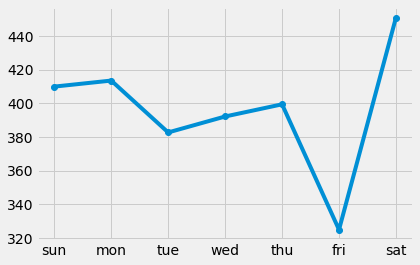

In [161]:
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat']
plt.plot(days, scores, marker='o', label='lstm');

We note that a naive model achieves an RMSE of 465kW. So our model performs well in comparison to this. 

## Alter the prior days

In [241]:
n_input = 11

# Call the build model function through the evaluate_model function
score, scores = evaluate_model(train, test, n_input)

Epoch 1/70
69/69 - 1s - loss: 636857.6250
Epoch 2/70
69/69 - 0s - loss: 260127.7969
Epoch 3/70
69/69 - 0s - loss: 291309.7812
Epoch 4/70
69/69 - 0s - loss: 297672.7500
Epoch 5/70
69/69 - 0s - loss: 273766.2500
Epoch 6/70
69/69 - 0s - loss: 271480.8750
Epoch 7/70
69/69 - 0s - loss: 270199.1562
Epoch 8/70
69/69 - 0s - loss: 262101.4062
Epoch 9/70
69/69 - 0s - loss: 269731.3438
Epoch 10/70
69/69 - 0s - loss: 262674.0938
Epoch 11/70
69/69 - 0s - loss: 257518.7500
Epoch 12/70
69/69 - 0s - loss: 255667.4219
Epoch 13/70
69/69 - 0s - loss: 258903.1250
Epoch 14/70
69/69 - 0s - loss: 256688.9062
Epoch 15/70
69/69 - 0s - loss: 253734.5469
Epoch 16/70
69/69 - 0s - loss: 251256.6094
Epoch 17/70
69/69 - 0s - loss: 251293.6094
Epoch 18/70
69/69 - 0s - loss: 249585.2031
Epoch 19/70
69/69 - 0s - loss: 248952.2031
Epoch 20/70
69/69 - 0s - loss: 243627.8594
Epoch 21/70
69/69 - 0s - loss: 372204.0938
Epoch 22/70
69/69 - 0s - loss: 259635.0938
Epoch 23/70
69/69 - 0s - loss: 258681.8906
Epoch 24/70
69/69 - 

In [242]:
summarize_scores('lstm', score, scores)

lstm: [382.915] 388.8, 399.6, 343.9, 383.1, 400.0, 310.5, 440.6


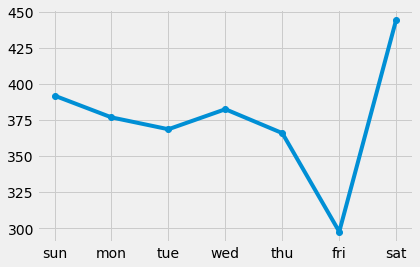

In [232]:
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat']
plt.plot(days, scores, marker='o', label='lstm');

### Optimal daily inputs
days- rmse \
7d - 397\
10d - 387 \
11d - 382 \
12d - 376\
13d - 377\
14d - 377\
21d - 480

We can see that the optimum number of prior days to use as predictors for the vanilla LSTM is 12, rmse=376.

## Encoder-Decoder LST Model with Univariate Input

In this section, we can update the vanilla LSTM to use and encoder-decoder model. 

This means that the model will not output a vector sequence directly. Instead, the model will be comprised of two sub models, the encoder to read and encode the input sequence, and the decoder that will read the encoded input sequence and make a one step prediction for each element in the output sequence. 

In [259]:
# Update our build model function
def build_model(train, n_input):
    """
    Construct and encoder-decoder LSTM model
    """
    # Prepare the data
    train_x, train_y = to_supervised(train, n_input)
    # Define parameters
    verbose, epochs, batch_size = 2, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # Reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
    
    # construct the model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    
    # fit the network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [260]:
# call the model using our previous universal evaluation functions
n_input = 12
score, scores = evaluate_model(train, test, n_input)

Epoch 1/70
69/69 - 2s - loss: 589346.6250
Epoch 2/70
69/69 - 1s - loss: 342857.2188
Epoch 3/70
69/69 - 1s - loss: 286940.0938
Epoch 4/70
69/69 - 1s - loss: 286451.9688
Epoch 5/70
69/69 - 1s - loss: 281183.8750
Epoch 6/70
69/69 - 1s - loss: 274851.8438
Epoch 7/70
69/69 - 1s - loss: 264585.3750
Epoch 8/70
69/69 - 1s - loss: 258750.5938
Epoch 9/70
69/69 - 1s - loss: 258706.5312
Epoch 10/70
69/69 - 1s - loss: 265568.9062
Epoch 11/70
69/69 - 1s - loss: 264095.3438
Epoch 12/70
69/69 - 1s - loss: 249381.0000
Epoch 13/70
69/69 - 1s - loss: 248876.3906
Epoch 14/70
69/69 - 1s - loss: 257234.9688
Epoch 15/70
69/69 - 1s - loss: 257361.5625
Epoch 16/70
69/69 - 1s - loss: 247430.2500
Epoch 17/70
69/69 - 1s - loss: 275184.1875
Epoch 18/70
69/69 - 1s - loss: 280422.0000
Epoch 19/70
69/69 - 1s - loss: 259131.9688
Epoch 20/70
69/69 - 1s - loss: 275021.0938
Epoch 21/70
69/69 - 1s - loss: 258891.7812
Epoch 22/70
69/69 - 1s - loss: 248943.9219
Epoch 23/70
69/69 - 1s - loss: 251231.2188
Epoch 24/70
69/69 - 

In [261]:
summarize_scores("Encoder-Decoder", score, scores)

Encoder-Decoder: [376.808] 394.4, 381.7, 327.7, 374.4, 365.4, 315.7, 460.3


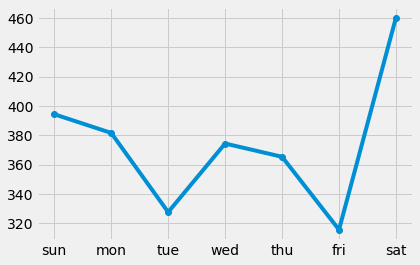

In [263]:
plt.plot(days, scores, marker='o', label="encoder-decoder LSTM")

### Narrative
The encoder decoder LSTM has produced a similar best score as the vanilla LSTM

## Encoder-Decoder LSTM Model with Multivariate Input

In this section we will update the Encoder-Decoder LSTM developed previously to use each of the eight time series variables to predict the next standard week of daily total power consumption.

Using multivariate inputs is useful for those pronblems where the output sequence is some function of the observations at prior time steps from multiple different features, not just (or including) the feature being forecasted. It is not always clears whether a problem has target/feature correlation but we should consider exploring it nonetheless.

1. We need to revise our `to_supervised` function to include all the eight features

In [275]:
# Convert history into inputs and outputs
def to_supervised_mv(train, n_input, n_out=7):
    # flatten data
    data= train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X,y = list(), list()
    in_start = 0
    
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        # Move along one time step
        in_start += 1
    return array(X), array(y)

In [276]:
# Create a function that makes a forecast based on: model fit on train set, the history,number of input time-steps

def forecast_mv(model, history, n_input):
    # flatten data
    data = array(history)
    # reshape to suit the shape of training data
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    # Retrieve the last observations for input data
    input_x = data[-n_input:, :]
    # Reshape into [1, n_input, n_features]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    
    # Forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # We only want the vector forecast
    yhat = yhat[0]
    return yhat

In [277]:
# Write a function to evaluate the model based on the walk_forward strategy
def evaluate_model(train, test, n_input):
    # fit model - call separate build_model function
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # Walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # Make weekly predictions
        yhat_sequence = forecast_mv(model, history, n_input)
        # Store the predictions
        predictions.append(yhat_sequence)
        # Get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # Evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecast(test[:, :, 0], predictions)
    
    return score, scores

In [278]:
# We can reuse the same encoder-decoder model function

def build_model(train, n_input):
    """
    Construct and encoder-decoder LSTM model
    """
    # Prepare the data
    train_x, train_y = to_supervised_mv(train, n_input)
    # Define parameters
    verbose, epochs, batch_size = 2, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # Reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
    
    # construct the model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    
    # fit the network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [284]:
n_input = 12
score, scores = evaluate_model(train, test, n_input)

Epoch 1/70
69/69 - 2s - loss: 81562320.0000
Epoch 2/70
69/69 - 1s - loss: 13027653.0000
Epoch 3/70
69/69 - 1s - loss: 48176328.0000
Epoch 4/70
69/69 - 1s - loss: 1219527.8750
Epoch 5/70
69/69 - 1s - loss: 434532.7812
Epoch 6/70
69/69 - 1s - loss: 408821.2188
Epoch 7/70
69/69 - 1s - loss: 375268.8125
Epoch 8/70
69/69 - 1s - loss: 372109.0625
Epoch 9/70
69/69 - 1s - loss: 418243.6250
Epoch 10/70
69/69 - 1s - loss: 375478.6250
Epoch 11/70
69/69 - 1s - loss: 365039.8750
Epoch 12/70
69/69 - 1s - loss: 368007.3125
Epoch 13/70
69/69 - 1s - loss: 373820.0625
Epoch 14/70
69/69 - 1s - loss: 348129.7188
Epoch 15/70
69/69 - 1s - loss: 362451.0312
Epoch 16/70
69/69 - 1s - loss: 395374.9375
Epoch 17/70
69/69 - 1s - loss: 324451.1875
Epoch 18/70
69/69 - 1s - loss: 325343.8125
Epoch 19/70
69/69 - 1s - loss: 324138.5000
Epoch 20/70
69/69 - 1s - loss: 365456.7188
Epoch 21/70
69/69 - 1s - loss: 310370.0312
Epoch 22/70
69/69 - 1s - loss: 347027.0312
Epoch 23/70
69/69 - 1s - loss: 305432.9375
Epoch 24/70
6

In [285]:
summarize_scores("Multivariate Encoder-Decoder ", score, scores)

Multivariate Encoder-Decoder : [369.808] 380.2, 367.0, 327.0, 383.3, 358.2, 295.3, 456.8


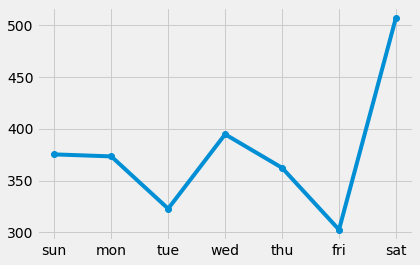

In [281]:
plt.plot(days, scores, marker='o', label="encoder-decoder LSTM")

Over a 12 day input period we can see that our model is skillful with an RMSE of 369kW. This is an improvement over our Vanilla and Univariate encoder-decoder models. This suggests the prior features do add to the predictive performance of the forecast. 

**Note: We have not normalised the features, this could be one way to investigate further improvements**

## CNN-LST Encoder-Decoder Moder with Univariate Input.

We can train a hybrid nn to work together passing a 1D representation of the data through a CNN which can then be interpreted by the LSTM. In this example we'll use only univariate input but multivariate is possible. 

#### Plan
1. We'll construct a model that is comprised of two convolutional layers followed by a max pooling layer, the results of which are then flattened. 

2. The first convolutionl layer reads across teh input sequence and projects the results onto feature maps. The second performs the same operation on the feature maps created by the first layer, attempting to amplify and salient features. We'll use 64 feature maps per convolytional layer and read the input sequences wuth a kernel size of three time steps. 

3. The max pooling layer simplifies the feature maps by keeping 1/4 of the values with the largest (max) signal. The distilled feature maps after the pooling layer are then flattened into one long vector that can then be used as input to the decoding process

Our build_model function will be altered to suit this new architecture

In [306]:
# Write a function to evaluate the model based on the walk_forward strategy
def evaluate_model(train, test, n_input):
    # fit model - call separate build_model function
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # Walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # Make weekly predictions
        yhat_sequence = forecast(model, history, n_input)
        # Store the predictions
        predictions.append(yhat_sequence)
        # Get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # Evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecast(test[:, :, 0], predictions)
    
    return score, scores

In [311]:
def build_model(train, n_input):
    # Prepare the data
    train_x, train_y = to_supervised(train, n_input)
    
    # Define parameters
    verbose, epochs, batch_size = 2, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    # Reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    
    # Define the model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    return model

In [314]:
n_input=12
score, scores = evaluate_model(train, test, n_input)

Epoch 1/20
69/69 - 2s - loss: 463676.9375
Epoch 2/20
69/69 - 0s - loss: 274817.0938
Epoch 3/20
69/69 - 0s - loss: 272576.6250
Epoch 4/20
69/69 - 0s - loss: 253314.8125
Epoch 5/20
69/69 - 1s - loss: 258473.8750
Epoch 6/20
69/69 - 0s - loss: 254474.9062
Epoch 7/20
69/69 - 0s - loss: 229851.1406
Epoch 8/20
69/69 - 0s - loss: 229725.1562
Epoch 9/20
69/69 - 0s - loss: 232071.1406
Epoch 10/20
69/69 - 0s - loss: 225317.3438
Epoch 11/20
69/69 - 1s - loss: 222179.3438
Epoch 12/20
69/69 - 0s - loss: 219230.6094
Epoch 13/20
69/69 - 0s - loss: 220229.5156
Epoch 14/20
69/69 - 0s - loss: 213544.8750
Epoch 15/20
69/69 - 1s - loss: 217516.2656
Epoch 16/20
69/69 - 1s - loss: 217691.3906
Epoch 17/20
69/69 - 1s - loss: 218810.3594
Epoch 18/20
69/69 - 1s - loss: 214917.6562
Epoch 19/20
69/69 - 1s - loss: 210346.6562
Epoch 20/20
69/69 - 1s - loss: 214349.3750


In [315]:
summarize_scores("CNN-LSTM ", score, scores)

CNN-LSTM : [377.403] 398.7, 382.9, 342.0, 362.4, 374.5, 304.9, 458.2


Text(0.5, 1.0, 'RMSE results per day for CNN-LSTM model')

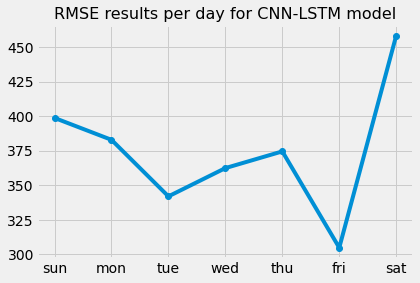

In [316]:
plt.plot(days, scores, marker='o', label='CNN-LSTM')
plt.title("RMSE results per day for CNN-LSTM model", fontsize=16)

**Narrative** \
We had to be careful not to overfit with this kind of neural network so we dropped the number of epochs to 20. In reality we could check overfitting with a validation set before applying to the test set. 

It's interesting to see yet again that Saturday and Sunday are having a consistently negative impact on our scores. We could remove their data from the set and replace with values from Friday. Alternatively could we split this problem into two separate ones - a weekend problem and weekday problem. You could then reintegrate their predictions before evaluating against the actual values. 

## ConvLSTM Encoder-Decoder Model with Univariate Input

An extension of the CNN-LSTM appraoch is to perform the convolutions of the CNN as part of the LSTM for each time step.

Unlike an LSTM that reads the data in directly in order to calculate internal state and state transitions, and unlike the CNN-LSTM that is interpreting the output from CNN models, the ConvLSTM is using convolutions directly as part of reading input into the LSTM units themselves.

The COnvLSTM2D class, by default, expects input data to have the shape: \
`[samples, timesteps, rows, cols, channels]` where each timestep of data is defined as an image of (rows*columns) data points

Assuming we're using two weeks of data as input we can spilt the 14 dats into two subsequences of length seven days. Teh ConvLSTM can then read across the two time steps and perform the CNN process on the seven days of data within each. The input would be `[n, 2, 1, 7, 1]`

OR: \
• **Samples**: n, for the number of exxamples in the training dataset \
• **Time**: 2, for the two subseuqneces that we split a window of 14 days into \
• **Rows**: 1, for the one-dimensional shape of each subsequence. \
• **Columns**: 7, for the seven days in each subsequence. \
• **Channels**: 1, for the single feature that we are working with as input.

Our build model function will be revised to suit the new train input shape as is the forecast function for the test input shape.

In [409]:
def build_model(train, n_steps, n_length, n_input):
    # Prepare data
    train_x, train_y = to_supervised(train, n_input)
    # Define Parameters
    verbose, epochs, batch_size = 2, 14, 64
    n_timesteps, n_features, n_outputs = train_x.shape[0], train_x.shape[2], train_y.shape[1]
    
    # Reshape into subsequences [samples, timesteps, rows, cols, channels]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    
    # Reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    
    # This line resolved the issue that tensorflow has converting arrays as floats to tensors
    train_x = np.asarray(train_x).astype(np.float32)
    train_y = np.asarray(train_y).astype(np.float32)
    
    # Define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1, 3), activation='relu', 
                         input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    
    # fit nn
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

The model expects 5D data as input. So we must also update the preparation of a single sample in the forecast function.

In [410]:
# Create a function that makes a forecast based on: model fit on train set, the history,number of input time-steps

def forecast_conv(model, history, n_steps, n_length, n_input):
    # flatten data
    data = array(history)
    # reshape to suit the shape of training data
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    # Retrieve the last observations for input data
    input_x = data[-n_input:, 0]
    # Reshape into [1, n_input, n_features]
    input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
    
    # This line resolved the issue that tensorflow has converting arrays as floats to tensors
    input_x = np.asarray(input_x).astype(np.float32) 
    
    # Forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # We only want the vector forecast
    yhat = yhat[0]
    return yhat

As we have revised the name of the forecast function to forecast_conv we need to make that change in the function that calls the forecast. 

In [411]:
# Write a function to evaluate the model based on the walk_forward strategy
def evaluate_model(train, test, n_steps, n_length, n_input):
    # fit model - call separate build_model function
    model = build_model(train, n_steps, n_length, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # Walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # Make weekly predictions
        yhat_sequence = forecast_conv(model, history, n_steps, n_length, n_input)
        # Store the predictions
        predictions.append(yhat_sequence)
        # Get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # Evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecast(test[:, :, 0], predictions)
    
    return score, scores

In [412]:
# Define the number and length of subsequences 
n_steps, n_length = 2, 7
# Define the total days to use as input
n_input = n_steps * n_length

# Call the model
score, scores = evaluate_model(train, test, n_steps, n_length, n_input)

Epoch 1/14
18/18 - 7s - loss: 1447994.1250
Epoch 2/14
18/18 - 0s - loss: 453306.5000
Epoch 3/14
18/18 - 0s - loss: 288515.3750
Epoch 4/14
18/18 - 0s - loss: 263410.4688
Epoch 5/14
18/18 - 0s - loss: 248864.7656
Epoch 6/14
18/18 - 0s - loss: 244553.4062
Epoch 7/14
18/18 - 0s - loss: 239206.2500
Epoch 8/14
18/18 - 1s - loss: 232740.9688
Epoch 9/14
18/18 - 0s - loss: 229992.0156
Epoch 10/14
18/18 - 1s - loss: 238174.2500
Epoch 11/14
18/18 - 0s - loss: 232807.5000
Epoch 12/14
18/18 - 0s - loss: 230636.0781
Epoch 13/14
18/18 - 0s - loss: 228987.0625
Epoch 14/14
18/18 - 0s - loss: 225681.9375


In [413]:
summarize_scores('convLSTSM', score, scores)

convLSTSM: [376.942] 394.0, 388.4, 337.4, 385.1, 365.1, 322.0, 435.2


Text(0.5, 1.0, 'RMSE results per day for Conv-LSTM model')

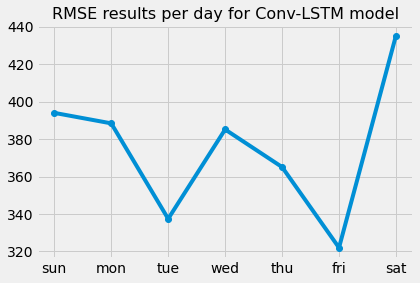

In [414]:
plt.plot(days, scores, marker='o', label="convLSTM")
plt.title("RMSE results per day for Conv-LSTM model", fontsize=16)

## SANDPIT

### Splitting a dataset from daily to weekly chunks

In [80]:
t  = daily_data.values[1:-328]
t.shape
# 1113 days, 8 features

(1113, 8)

In [81]:
array(split(t, len(t)/7)).shape
# 159 weekly periods, 7 days per week, 8 features

(159, 7, 8)

### Calculate the Naive RMSE for our dataset

Where did machine learning mastery get their value of 465kW from? **See the naive notebook in the directory**. 

The Naive forecast uses the previous period's values as the predicted (forecast) values for the current period.

we'll use the following methods to calculate the following naive values:
1. daily - where we use the previous day to predict the next day (this cannot be used to predict 7 day forecast)
2. weekly - where we average the previous weeks daily usage and use that value to predict the next weeks average
3. daily/weekly - Get daily sq_error values as per method 1, then average these to the weekly timeframe. Then use this weeks average to calculate next week's average. 

In [186]:
daily.drop(columns=["Gap_mean", "sq_error"], inplace=True)

In [187]:
daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,day_of_week,year,month
datetime,,,,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319,Saturday,2006,12
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732,Sunday,2006,12
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281,Monday,2006,12
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043,Tuesday,2006,12
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011,Wednesday,2006,12


In [188]:
daily["forecast"] = daily.Global_active_power.shift(1)

In [191]:
daily.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,day_of_week,year,month,forecast
datetime,,,,,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319,Saturday,2006,12,NaN
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732,Sunday,2006,12,1209.176


In [192]:
daily["sq_error"] = (daily.Global_active_power - daily.forecast)**2

In [204]:
daily.head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,day_of_week,year,month,forecast,sq_error
datetime,,,,,,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319,Saturday,2006,12,NaN,NaN
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732,Sunday,2006,12,1209.176,4.758000e+06
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281,Monday,2006,12,3390.460,1.408100e+06
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043,Tuesday,2006,12,2203.826,2.890482e+05
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011,Wednesday,2006,12,1666.194,3.131007e+05
2006-12-21,1723.288,144.434,347096.41,7266.4,1765.0,2692.0,10456.0,13808.466697,Thursday,2006,12,2225.748,2.524661e+05
2006-12-22,2341.338,186.906,347305.75,9897.0,3151.0,350.0,11131.0,24390.300043,Friday,2006,12,1723.288,3.819858e+05
2006-12-23,4773.386,221.470,345795.95,20200.4,2669.0,425.0,14726.0,61736.433386,Saturday,2006,12,2341.338,5.914857e+06
2006-12-24,2550.012,149.900,348029.91,11002.2,1703.0,5082.0,6891.0,28824.199967,Sunday,2006,12,4773.386,4.943392e+06


In [194]:
naive_mse = daily.sq_error.mean()

In [195]:
naive_mse

279860.1872329491

In [197]:
f'The daily naive rmse is: {round(sqrt(naive_mse),2)}'

'The daily naive rmse is: 529.02'

In [198]:
# Now this figure is higher than the figure given by MLM, however this is a weekly, not daily, problem. 
# If we average over 7 day periods perhaps we will narrow the current gap?

In [205]:
# Lets aggregate the values to weekly averages
# resample data to daily
weekly_groups = daily.resample('W')
weekly_data = weekly_groups.mean()

In [213]:
# Ok we have weekly data based on standard weeks by the looks, so starting on Sundays and finishing on Saturdays
weekly_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,year,month,forecast,sq_error
datetime,,,,,,,,,,,,
2006-12-17,2299.818000,130.464000,219638.925000,9789.700000,1016.500000,2366.500000,9133.500000,25813.800026,2006.0,12.0,NaN,NaN
2006-12-24,2497.684571,168.063143,347572.040000,10574.314286,1598.571429,3060.000000,11068.857143,25900.647633,2006.0,12.0,2299.818000,39151.180089
2006-12-31,2820.474857,207.506857,348350.118571,11864.485714,2033.857143,3232.857143,9610.428571,32130.771421,2006.0,12.0,2497.684571,104193.568552
2007-01-07,2137.295429,192.707714,346927.155714,9017.457143,836.714286,2514.142857,7741.857143,24528.876188,2007.0,1.0,2820.474857,466734.131623
2007-01-14,2311.137143,227.206000,345989.208571,9836.828571,1917.142857,2712.714286,11908.000000,21981.095236,2007.0,1.0,2137.295429,30220.941626


Now we just repeat the steps from the daily data to get our naive forecast, squared error, mse and finally our naive RMSE.


In [207]:
# Take this week's mean GAP to forecast next week's mean GAP
weekly_data["forecast"] = weekly_data.Global_active_power.shift(1)

In [209]:
weekly_data["sq_error"] = (weekly_data.Global_active_power - weekly_data.forecast)**2

In [210]:
wk_mse = weekly_data.sq_error.mean()

In [211]:
wk_mse

103052.64988330878

In [212]:
sqrt(wk_mse)

321.01814572280614

Ouch!! That's actually dropped the figure way off. In fact, in comparison to our vanilla LSTM this has actually created a relatively high perforing forecasting method!! HOWEVER WE ARE NOT ON A LIKE FOR LIKE BASIS... THE MODEL FORECASTS A VALUE FOR EACH OF THE NEXT SEVEN DAYS... NOT A WEEKLY AVERAGE.

So averaging the weekly GAP and then forecasting from there has not aligned our naive forecast scores. What about using daily forecasts, then averaging those to the weekly level. And then using that value to predict the next 7 day average??

In [219]:
daily.head(20)
# ok so the forecast is good, we now just need to resample that to the weekly level

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,day_of_week,year,month,forecast,sq_error
datetime,,,,,,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319,Saturday,2006,12,NaN,NaN
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732,Sunday,2006,12,1209.176,4.758000e+06
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281,Monday,2006,12,3390.460,1.408100e+06
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043,Tuesday,2006,12,2203.826,2.890482e+05
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011,Wednesday,2006,12,1666.194,3.131007e+05
2006-12-21,1723.288,144.434,347096.41,7266.4,1765.0,2692.0,10456.0,13808.466697,Thursday,2006,12,2225.748,2.524661e+05
2006-12-22,2341.338,186.906,347305.75,9897.0,3151.0,350.0,11131.0,24390.300043,Friday,2006,12,1723.288,3.819858e+05
2006-12-23,4773.386,221.470,345795.95,20200.4,2669.0,425.0,14726.0,61736.433386,Saturday,2006,12,2341.338,5.914857e+06
2006-12-24,2550.012,149.900,348029.91,11002.2,1703.0,5082.0,6891.0,28824.199967,Sunday,2006,12,4773.386,4.943392e+06


In [216]:
weekly = daily.resample('W')
weekly = weekly.mean()

In [223]:
weekly.head(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,year,month,forecast,sq_error
datetime,,,,,,,,,,,,
2006-12-17,2299.818000,130.464000,219638.925000,9789.700000,1016.500000,2366.500000,9133.500000,25813.800026,2006.0,12.0,1209.176000,1.189500e+06
2006-12-24,2497.684571,168.063143,347572.040000,10574.314286,1598.571429,3060.000000,11068.857143,25900.647633,2006.0,12.0,2617.748571,1.441536e+04
2006-12-31,2820.474857,207.506857,348350.118571,11864.485714,2033.857143,3232.857143,9610.428571,32130.771421,2006.0,12.0,2685.591429,1.819354e+04


In [222]:
# Ok so now find the square_error of the daily forecast averages on the weekly aggregation
weekly["sq_error"] = (weekly.Global_active_power - weekly.forecast)**2

In [224]:
weekly_mse = weekly.sq_error.mean()
weekly_mse

15017.796890598695

In [225]:
sqrt(weekly_mse)


122.54712110285861

Agh this appears to be a good value but we're measuring averages against averages. Our original LSTM model makes a forecast for each of the following seven days and then measures the RMSE. 

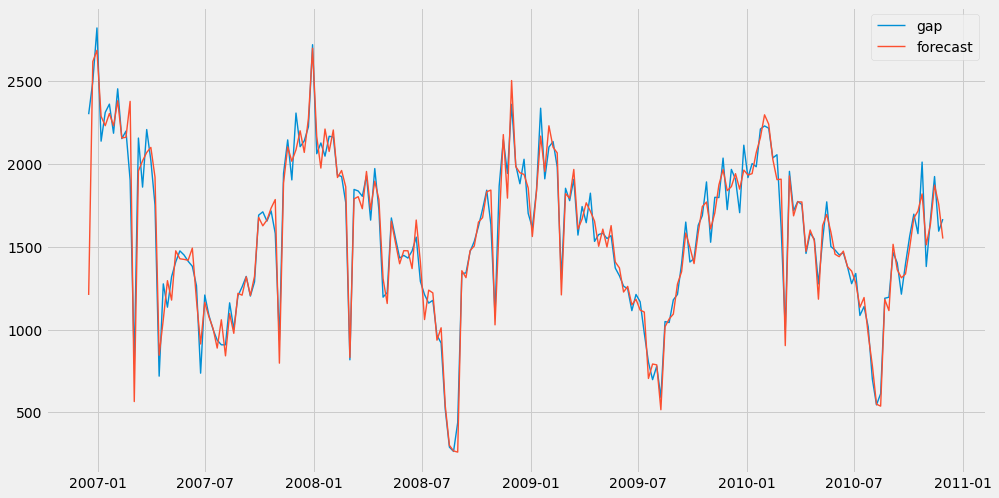

In [228]:
plt.figure(figsize=(15, 8))
plt.plot(weekly.Global_active_power, label=("gap"), linewidth=1.4)
plt.plot(weekly.forecast, label=("forecast"), linewidth=1.4)
plt.legend()
plt.show()

### What rmse does the average of the GAP give?

1.) take the average of the daily global_active_power \
2.) create a new feature that holds this value in every column \
3.) create a new feature that holds the individual squared error for each day \
4.) calculate the root mean squared error from the individual values \

In [164]:
daily.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,day_of_week,year,month
datetime,,,,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319,Saturday,2006,12
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732,Sunday,2006,12


In [166]:
gap_mean = daily.Global_active_power.mean()
gap_mean

1567.8390693481276

In [167]:
daily["Gap_mean"] = gap_mean

In [171]:
daily["sq_error"] = (daily.Global_active_power - daily.Gap_mean)**2

In [174]:
# What's the mean of the inidividual squared errors?
mse = daily.sq_error.mean()
mse

356528.0632931837

In [180]:
# And now what is the root of this value
f"Coin toss rmse: {sqrt(mse)}"

'Coin toss rmse: 597.0997096743422'

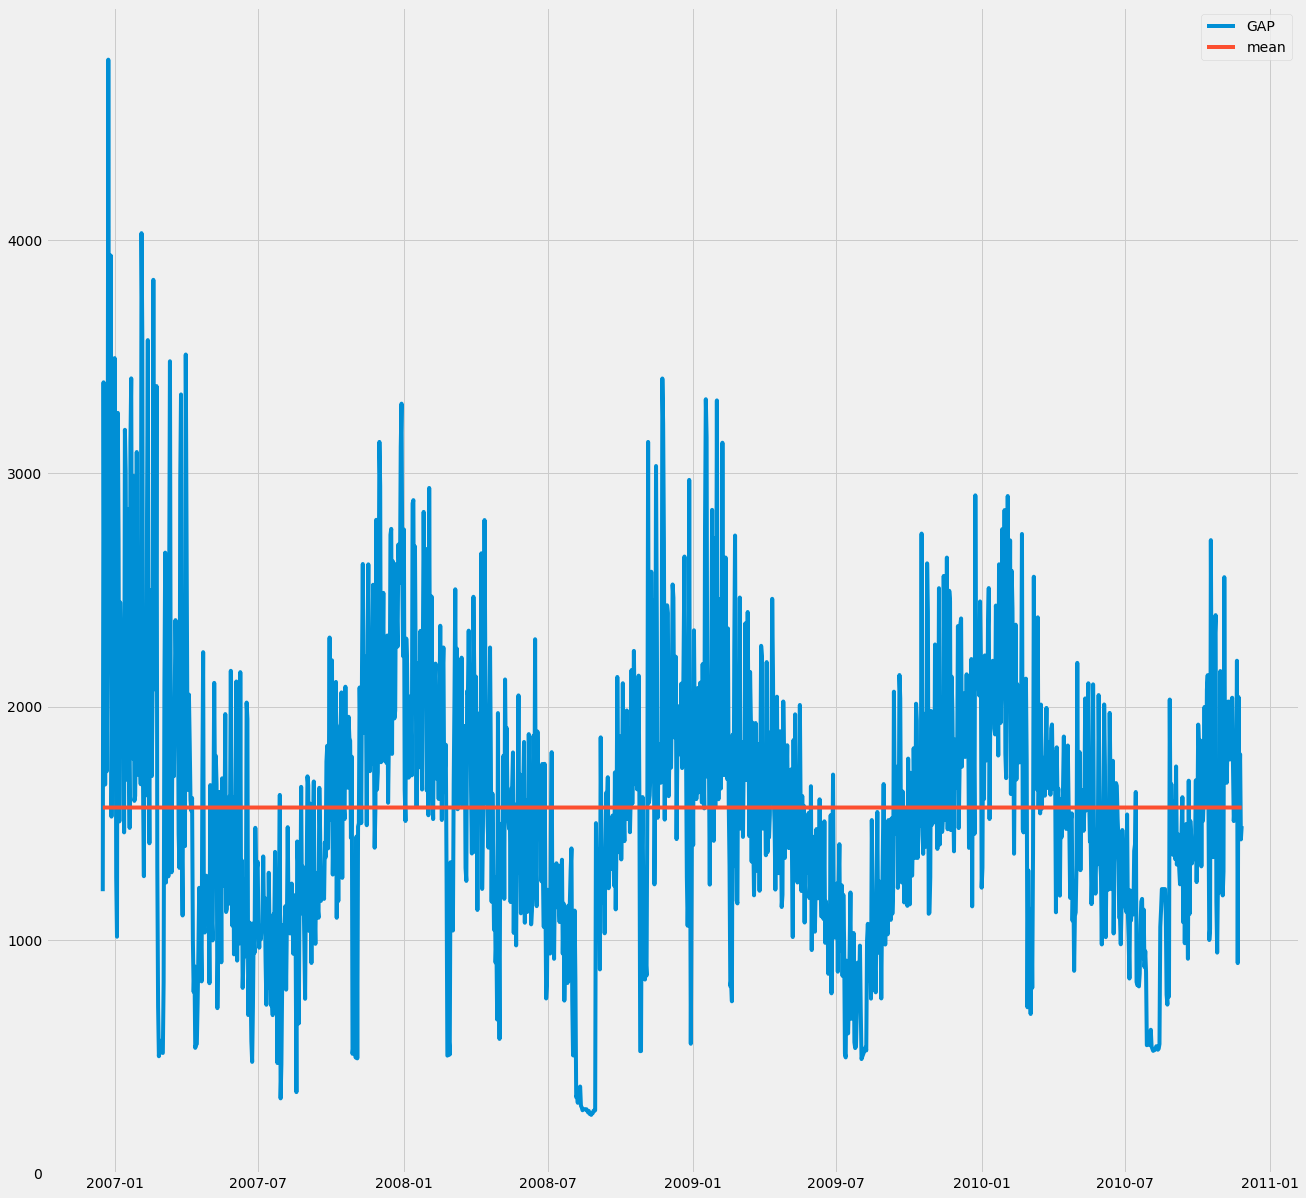

In [184]:
plt.figure(figsize=(20,20))
plt.plot(daily.Global_active_power, label="GAP")
#plt.plot(daily.sq_error, label="SE")
plt.plot(daily.Gap_mean, label="mean")
plt.legend()
plt.ylim(0, )
plt.show()

In [181]:
daily

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,day_of_week,year,month,Gap_mean,sq_error
datetime,,,,,,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319,Saturday,2006,12,1567.839069,1.286392e+05
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732,Sunday,2006,12,1567.839069,3.321947e+06
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281,Monday,2006,12,1567.839069,4.044794e+05
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043,Tuesday,2006,12,1567.839069,9.673692e+03
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011,Wednesday,2006,12,1567.839069,4.328442e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-22,2041.536,142.354,345883.85,8660.4,4855.0,2110.0,10136.0,16924.600023,Monday,2010,11,1567.839069,2.243888e+05
2010-11-23,1577.536,137.450,346428.76,6731.2,1871.0,458.0,7611.0,16352.266679,Tuesday,2010,11,1567.839069,9.403046e+01
2010-11-24,1796.248,132.460,345644.59,7559.4,1096.0,2848.0,12224.0,13769.466664,Wednesday,2010,11,1567.839069,5.217064e+04
